# Clase 4

- [FBI NICS Firearm Background Check Data](https://github.com/BuzzFeedNews/nics-firearm-background-checks)
- [Forecasting Book](https://otexts.com/fpp2/)

## ARIMA

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
sns.set(rc={'figure.figsize': (12,8)})

In [3]:
df = pd.read_csv('data/firearms.csv', parse_dates=['month'])

In [4]:
df.head()

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2020-04-01,Alabama,21276.0,386.0,28951.0,12512.0,1455.0,1272,0.0,27.0,...,0.0,0.0,0.0,31.0,30.0,7.0,0.0,0.0,0.0,70748
1,2020-04-01,Alaska,85.0,68.0,3942.0,3275.0,510.0,245,0.0,1.0,...,0.0,0.0,0.0,11.0,9.0,3.0,0.0,0.0,0.0,8560
2,2020-04-01,Arizona,4500.0,675.0,33391.0,13143.0,2369.0,3121,0.0,26.0,...,0.0,0.0,0.0,25.0,19.0,3.0,0.0,0.0,0.0,59986
3,2020-04-01,Arkansas,3085.0,801.0,13814.0,8463.0,612.0,678,1.0,28.0,...,0.0,1.0,0.0,26.0,15.0,1.0,0.0,1.0,0.0,30575
4,2020-04-01,California,24460.0,0.0,59219.0,31759.0,6330.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,122999


In [5]:
total = df[['totals', 'month']].groupby('month').sum();

In [6]:
total.head()

,totals
month,
1998-11-01,21176
1998-12-01,870722
1999-01-01,585974
1999-02-01,690215
1999-03-01,741687


In [7]:
total = total.drop(total.iloc[[0]].index)

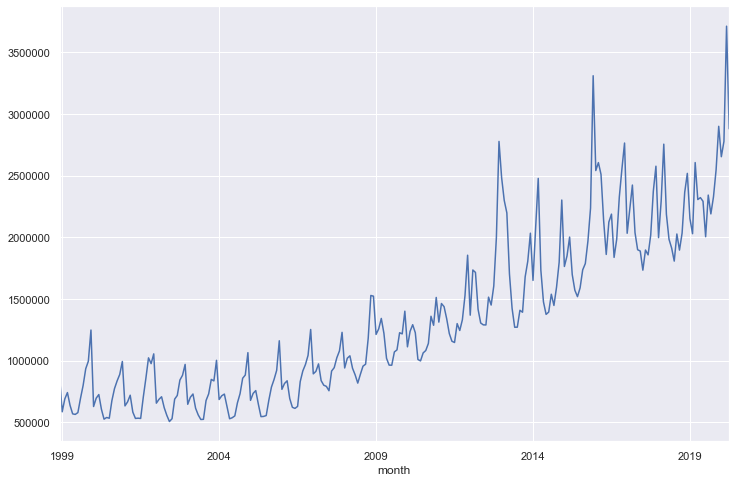

In [8]:
total['totals'].plot();

In [9]:
import statsmodels.api as sm

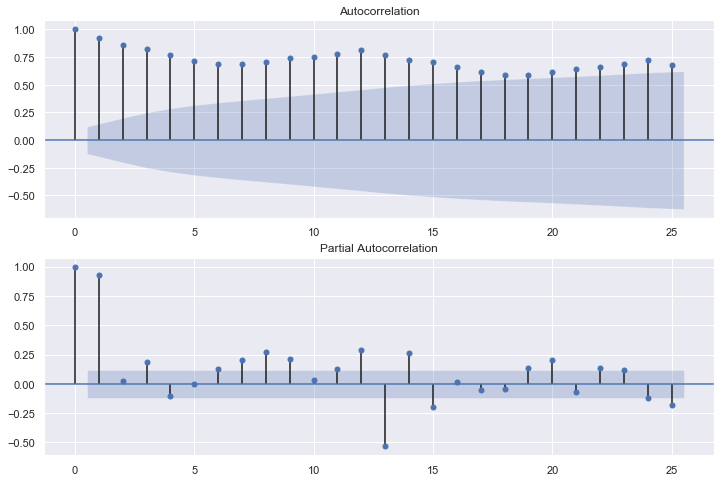

In [10]:
fig, (ax1, ax2) = plt.subplots(2)
sm.graphics.tsa.plot_acf(total['totals'], ax=ax1)
sm.graphics.tsa.plot_pacf(total['totals'], ax=ax2);

In [11]:
total['diferencias'] = total.pct_change()

In [12]:
diferencias = total[['diferencias']].dropna()

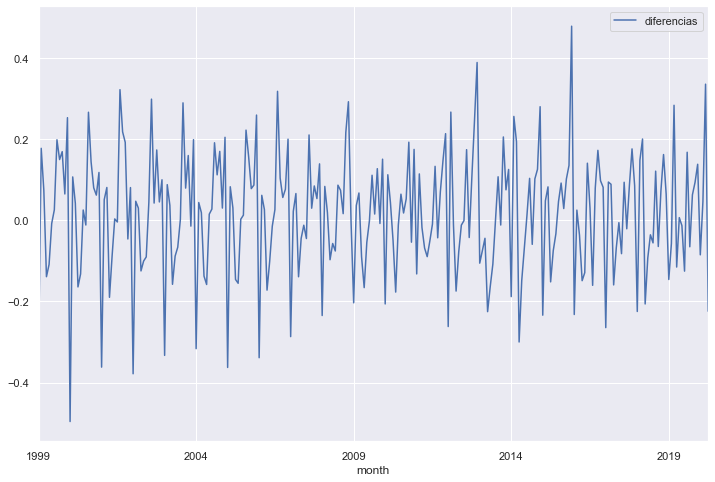

In [13]:
diferencias.plot();

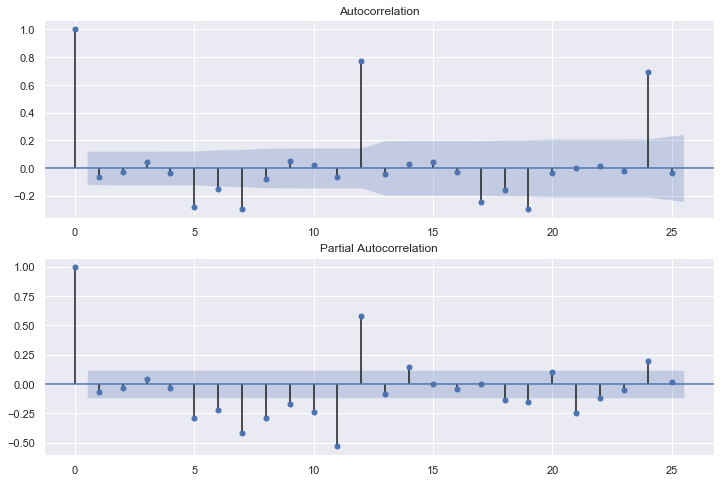

In [14]:
fig, (ax1, ax2) = plt.subplots(2)
sm.graphics.tsa.plot_acf(diferencias, ax=ax1)
sm.graphics.tsa.plot_pacf(diferencias.dropna(), ax=ax2);

In [15]:
# Código adaptado de https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing
def hurst(ts):
    lags = range(2, 100)
    tau = [np.sqrt(np.std(np.subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    poly = np.polyfit(np.log(lags), np.log(tau), 1)

    return poly[0] * 2.0

In [16]:
hurst(total['totals'].values)

0.07565958336690412

In [17]:
hurst(diferencias.values)

-0.019200619571261394

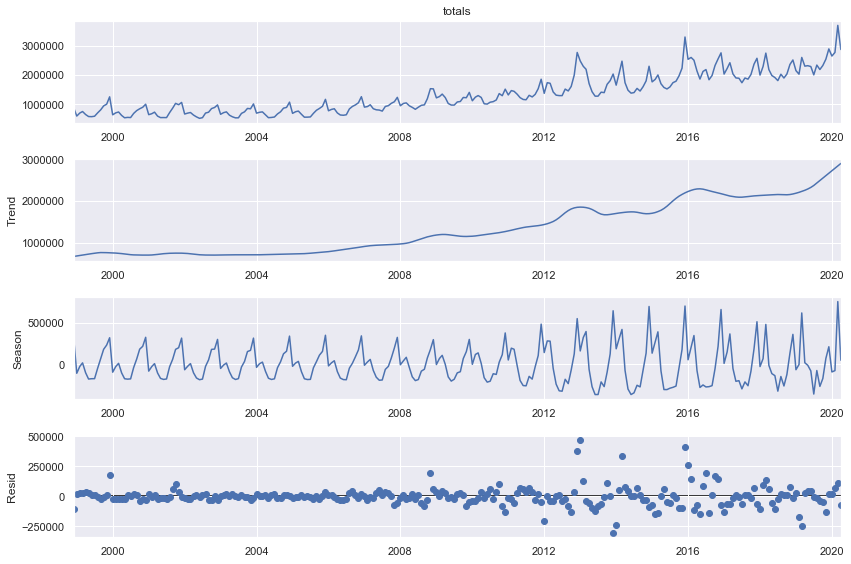

In [18]:
stl_decomposition = sm.tsa.STL(total['totals'], period=12)
res = stl_decomposition.fit()
res.plot();

In [19]:
import pmdarima as pm
from sklearn.model_selection import train_test_split

In [20]:
train, test = train_test_split(total['totals'].values, train_size=0.9, shuffle=False)

model = pm.auto_arima(train, seasonal=True, m=12, suppress_warnings=True)

In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  231
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -3088.472
Date:                              Wed, 03 Jun 2020   AIC                           6188.943
Time:                                      13:11:44   BIC                           6209.572
Sample:                                           0   HQIC                          6197.265
                                              - 231                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   8662.9477   1.15e+04      0.753      0.452   -1.39e+04    3.12e+04
ar.L1         -0.0489      0.099     -0.495      0.621      -0.242       0.145
ar.L2         -0.2062      0.116     -1.776      0.076      -0.434       0.021
ar.S.L12       0.8905      0.088     10.157      0.000       0.719       1.062
ma.S.L12      -0.4882      0.196     -2.488      0.013      -0.873      -0.104
sigma2      4.725e+10      0.000   2.12e+14      0.000    4.72e+10    4.72e+10
===================================================================================
Ljung-Box (Q):                       47.75   Jarque-Bera (JB):               386.10
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):               4.95   Skew:                             0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.55e+31. Standard errors may be unstable.
"""

In [22]:
forecasts = model.predict(len(test))  # predict N steps into the future

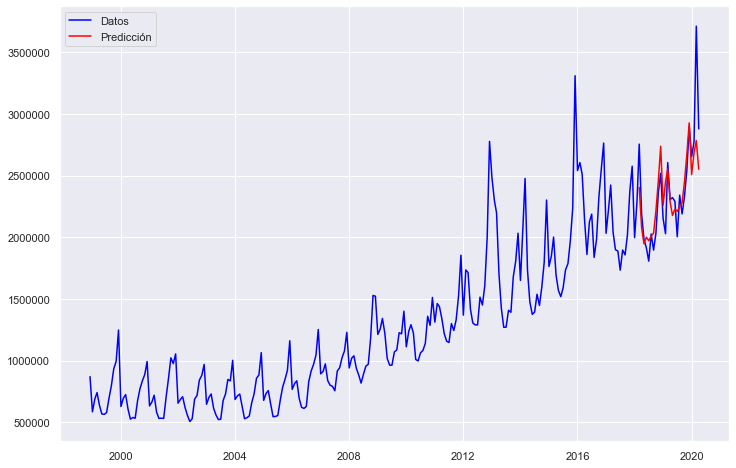

In [23]:
x = np.arange(total['totals'].shape[0])
plt.plot(total['totals'].index, total['totals'], c='blue', label = 'Datos')
plt.plot(total['totals'].index[len(train):], forecasts, c='red', label = 'Predicción')
plt.legend();

In [24]:
import pyflux as pf

In [25]:
residuos = model.resid()

In [26]:
model_garch = pf.GARCH(residuos,1,1)
x = model_garch.fit()
x.summary()

GARCH(1,1)                                                                                                
======================================================= ==================================================
Dependent Variable: Series                              Method: MLE                                       
Start Date: 1                                           Log Likelihood: -3038.9107                        
End Date: 230                                           AIC: 6085.8215                                    
Number of observations: 230                             BIC: 6099.5738                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Vol Constant                             513.977                                                          
q(1)                                 

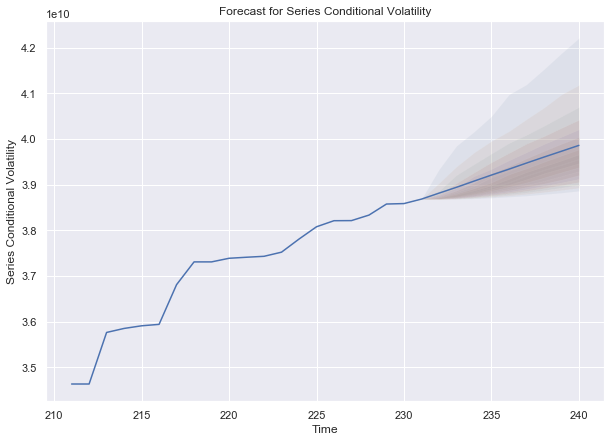

In [27]:
model_garch.plot_predict(h=10)

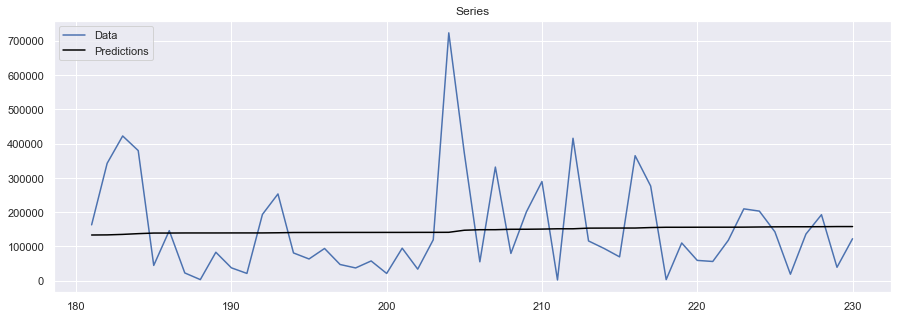

In [28]:
model_garch.plot_predict_is(h=50,figsize=(15,5))

## Facebook Prophet

In [29]:
from fbprophet import Prophet

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [30]:
train_df = total[:len(train)]
test_df = total[len(train):]

In [31]:
data = pd.DataFrame({'ds': train_df.index, 'y': train_df['totals']})

prophet_model = Prophet()
#prophet_model.add_seasonality(name='annual', period=12, fourier_order=5)
prophet_model.fit(data);

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [32]:
future = prophet_model.make_future_dataframe(freq='M', periods=len(test))
prophet_forecast = prophet_model.predict(future)

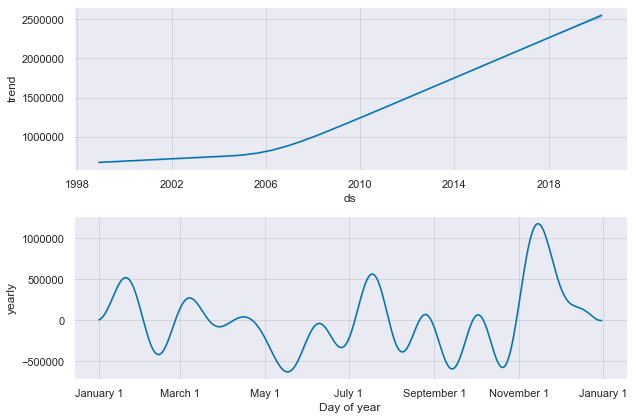

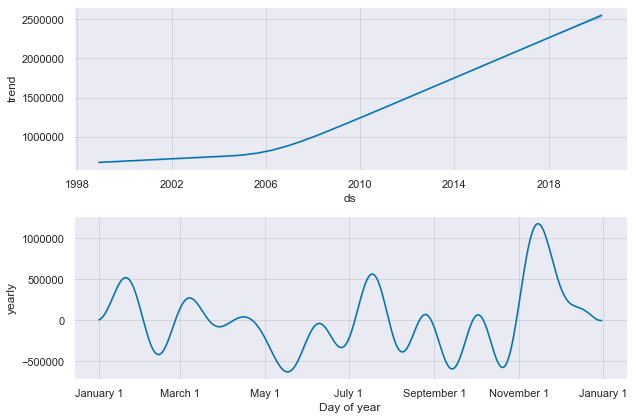

In [33]:
prophet_model.plot_components(prophet_forecast)

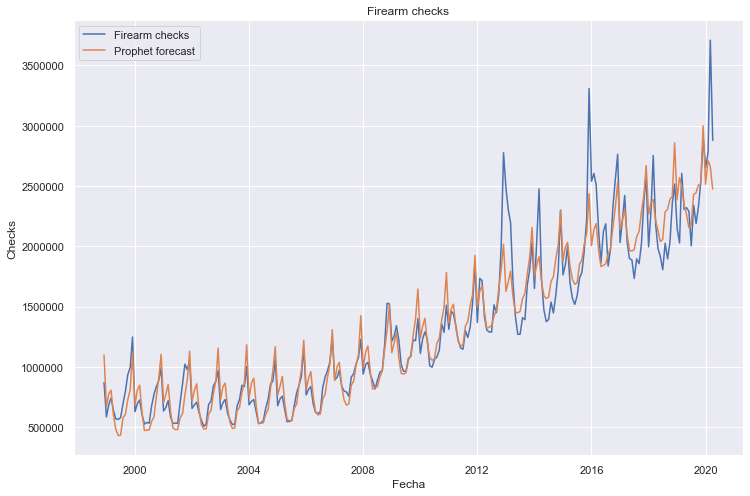

In [34]:
ax = sns.lineplot(x=total.index, y=total['totals'], label='Firearm checks')
sns.lineplot(y=prophet_forecast['yhat'], x=prophet_forecast['ds'], label='Prophet forecast', ax=ax)
ax.set_xlabel('Fecha')
ax.set_ylabel('Checks')
ax.set_title('Firearm checks');